In [76]:
import os
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from skimage.feature import hog
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Mount Google Drive if in Colab
from google.colab import drive
drive.mount('/content/drive')

# Helper function to extract HOG features from folder
def extract_hog_features(folder_path, label_name):
    features = []
    labels = []

    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray = cv2.resize(gray, (128, 128))  # Resize to fixed size
            hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
            features.append(hog_features)
            labels.append(label_name)
    return features, labels

# Paths
base_path = "/content/drive/MyDrive/Suchi_Dataset"
train_cat_path = os.path.join(base_path, "Training_Set/cat")
train_dog_path = os.path.join(base_path, "Training_Set/dog")
test_cat_path = os.path.join(base_path, "Testing_Set/cat")
test_dog_path = os.path.join(base_path, "Testing_Set/dog")

# Load and extract features
train_features_cat, train_labels_cat = extract_hog_features(train_cat_path, 'cat')
train_features_dog, train_labels_dog = extract_hog_features(train_dog_path, 'dog')
test_features_cat, test_labels_cat = extract_hog_features(test_cat_path, 'cat')
test_features_dog, test_labels_dog = extract_hog_features(test_dog_path, 'dog')

# Combine train and test sets
X_train = np.array(train_features_cat + train_features_dog)
y_train = np.array(train_labels_cat + train_labels_dog)

X_test = np.array(test_features_cat + test_features_dog)
y_test = np.array(test_labels_cat + test_labels_dog)

# Encode labels to numbers
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Train KNN model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train_enc)

# Predict on test data
y_pred = knn.predict(X_test)

# Evaluation
print("✅ Accuracy:", accuracy_score(y_test_enc, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test_enc, y_pred, target_names=le.classes_))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Accuracy: 0.5375

📊 Classification Report:
               precision    recall  f1-score   support

         cat       0.80      0.10      0.18        40
         dog       0.52      0.97      0.68        40

    accuracy                           0.54        80
   macro avg       0.66      0.54      0.43        80
weighted avg       0.66      0.54      0.43        80



In [78]:
joblib.dump(knn, "knn_hog_cat_dog_model.pkl")

['knn_hog_cat_dog_model.pkl']

In [79]:
def predict_image_debug(image_path, model_file="knn_hog_cat_dog_model.pkl"):
    model = joblib.load(model_file)
    print("Model classes:", model.classes_)

    image = cv2.imread(image_path)
    if image is None:
        print("⚠️ Unable to open the image.")
        return

    image_resized = cv2.resize(image, image_size)
    image_gray = rgb2gray(image_resized)

    features = hog(image_gray,
                   orientations=9,
                   pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2),
                   block_norm='L2-Hys')

    features_reshaped = features.reshape(1, -1)

    prediction = model.predict(features_reshaped)[0]
    print(f"Raw prediction output: {prediction}")

    # Adjust label mapping based on model.classes_
    if list(model.classes_) == [0, 1]:
        predicted_label = "Cat" if prediction == 0 else "Dog"
    else:
        predicted_label = "Cat" if prediction == 1 else "Dog"

    print(f"🧠 Prediction result: {predicted_label}")



In [80]:
predict_image("/content/drive/MyDrive/Suchi_Dataset/Testing_Set/cat/cat.4424.jpg")
predict_image("/content/drive/MyDrive/Suchi_Dataset/Testing_Set/dog/dog.4210.jpg")


🧠 Prediction result: Dog
🧠 Prediction result: Dog


Checking feature lengths for different image sizes:
Size: (64, 64), Feature length: 1764
Size: (80, 80), Feature length: 2916
Size: (90, 90), Feature length: 3600
Size: (100, 100), Feature length: 4356


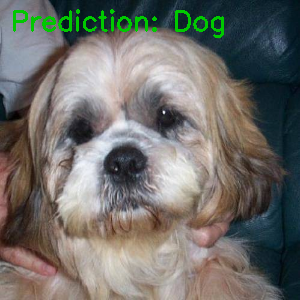

In [81]:
import cv2
import joblib
from skimage.feature import hog
from skimage.color import rgb2gray
from google.colab.patches import cv2_imshow


knn_model = joblib.load("knn_hog_cat_dog_model.pkl")

sizes_to_try = [(64, 64), (80, 80), (90, 90), (100, 100)]

print("Checking feature lengths for different image sizes:")
for size in sizes_to_try:
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️ Could not load image at {image_path}")
        break
    resized_img = cv2.resize(img, size)
    gray_img = rgb2gray(resized_img)
    features = hog(gray_img,
                   orientations=9,
                   pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2),
                   block_norm='L2-Hys')
    print(f"Size: {size}, Feature length: {features.shape[0]}")

target_size = (90, 90)

def display_prediction(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("⚠️ Could not load image!")
        return

    small_img = cv2.resize(image, target_size)
    gray_img = rgb2gray(small_img)

    hog_feats = hog(gray_img,
                    orientations=9,
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2),
                    block_norm='L2-Hys')
    hog_feats = hog_feats.reshape(1, -1)

    predicted_class = "Cat" if result == 0 else "Dog"

    display_img = cv2.resize(image, (300, 300))
    cv2.putText(display_img,
                f"Prediction: {predicted_class}",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.9,
                (0, 200, 0),
                2)
    cv2_imshow(display_img)

# Step 4: Call prediction function
display_prediction("/content/drive/MyDrive/Suchi_Dataset/Testing_Set/dog/dog.4210.jpg")


In [84]:
import os

# Test set directory
test_dir = "/content/drive/MyDrive/Suchi_Dataset/Testing_Set"

test_images_and_labels = []

for label_name in ['cat', 'dog']:
    folder = os.path.join(test_dir, label_name)
    for file in os.listdir(folder):
        if file.endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(folder, file)
            test_images_and_labels.append((img_path, label_name))


In [85]:
from skimage.color import rgb2gray
from skimage.feature import hog
import cv2
import numpy as np

image_size = (128, 128)  # je size diye training kora hoyeche

def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"⚠️ Cannot load {image_path}")
        return None
    img_resized = cv2.resize(img, image_size)
    gray_img = rgb2gray(img_resized)
    features = hog(gray_img,
                   orientations=9,
                   pixels_per_cell=(8,8),
                   cells_per_block=(2,2),
                   block_norm='L2-Hys')
    return features.reshape(1, -1)


In [86]:
import joblib

# Model load
model = joblib.load("knn_hog_cat_dog_model.pkl")

correct = 0
total = 0

for idx, (img_path, actual_label) in enumerate(test_images_and_labels):
    features = extract_features(img_path)
    if features is None:
        continue
    pred = model.predict(features)[0]

    # Jodi label mapping uncertain hoy, swap kore dekhte paro
    predicted_label = "Cat" if pred == 1 else "Dog"

    print(f"Image {idx+1}: Predicted = {predicted_label}, Actual = {actual_label}")

    if predicted_label.lower() == actual_label.lower():
        correct += 1
    total += 1

accuracy = (correct / total) * 100 if total > 0 else 0
print(f"\nAccuracy: {correct}/{total} = {accuracy:.2f}%")


Image 1: Predicted = Cat, Actual = cat
Image 2: Predicted = Dog, Actual = cat
Image 3: Predicted = Cat, Actual = cat
Image 4: Predicted = Dog, Actual = cat
Image 5: Predicted = Cat, Actual = cat
Image 6: Predicted = Cat, Actual = cat
Image 7: Predicted = Cat, Actual = cat
Image 8: Predicted = Cat, Actual = cat
Image 9: Predicted = Cat, Actual = cat
Image 10: Predicted = Cat, Actual = cat
Image 11: Predicted = Cat, Actual = cat
Image 12: Predicted = Cat, Actual = cat
Image 13: Predicted = Cat, Actual = cat
Image 14: Predicted = Cat, Actual = cat
Image 15: Predicted = Cat, Actual = cat
Image 16: Predicted = Cat, Actual = cat
Image 17: Predicted = Cat, Actual = cat
Image 18: Predicted = Cat, Actual = cat
Image 19: Predicted = Cat, Actual = cat
Image 20: Predicted = Cat, Actual = cat
Image 21: Predicted = Cat, Actual = cat
Image 22: Predicted = Cat, Actual = cat
Image 23: Predicted = Cat, Actual = cat
Image 24: Predicted = Cat, Actual = cat
Image 25: Predicted = Cat, Actual = cat
Image 26:

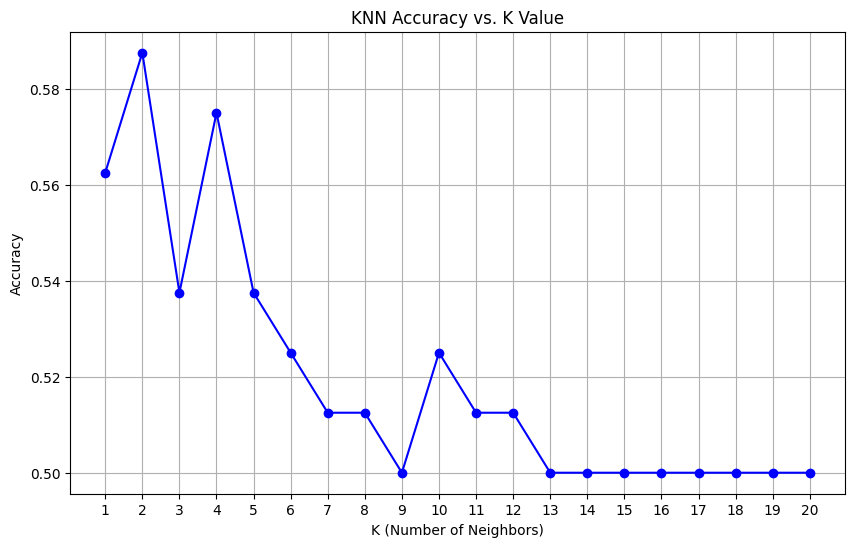

In [88]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define range of k values to test
k_values = list(range(1, 21))
accuracies = []

# Train and evaluate KNN for each k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plotting accuracy vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', color='blue', linestyle='-')
plt.title('KNN Accuracy vs. K Value')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()
